In [16]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mbptycho.code.simulation import reloadSimulation
from mbptycho.code.recons.recons import DisplacementFullModelReconstruction
from matplotlib.colors import LogNorm, SymLogNorm, Normalize, LinearSegmentedColormap
from skimage.registration import phase_cross_correlation
from matplotlib import ticker
from scipy.stats import circmean
import skimage

import copy
import os
base_path = os.environ['HOME']

cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

from matplotlib.colors import LogNorm, Normalize, LinearSegmentedColormap
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [4]:
strain_type = 'point_inclusion'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/weak_peaks/'
sim_data_path = f'{data_path}/sim_{strain_type}.lz4'
sample_data_path = f'{data_path}/sample_{strain_type}.lz4'

In [5]:
sm = reloadSimulation(sim_data_path, reload_sim=True)#sim_params={"HKL_list":[[1, 2, 0]]}
#sm.sample.Ux_trunc.shape, sm.sample.params.sample_pix_size

File exists. Reloading...


In [6]:
def calc_error(img1, img2):
    src_freq = np.fft.fftn(img1)
    target_freq = np.fft.fftn(img2)
    src_amp = np.sum(np.real(src_freq * src_freq.conj()))
    src_amp /= src_freq.size
    target_amp = np.sum(np.real(target_freq * target_freq.conj()))
    target_amp /= target_freq.size
    
    image_product = src_freq * target_freq.conj()
    cross_correlation = np.fft.ifftn(image_product)
    maxima = np.unravel_index(np.argmax(np.abs(cross_correlation)),
                              cross_correlation.shape)
    error = 1.0 - cross_correlation[maxima] * cross_correlation[maxima].conj() / (src_amp * target_amp)
    return np.sqrt(np.abs(error))

In [7]:
recons_separate = {'rho': np.load(f'{data_path}/rho_phase_sep_mags.npz')['arr_0'],
                   'ux': np.load(f'{data_path}/ux_displacement_to_phase.npz')['arr_0'],
                   'uy': np.load(f'{data_path}/uy_displacement_to_phase.npz')['arr_0'],
                   'df': pd.read_pickle(f'{data_path}/df_phase_sep_mags.gz')}

In [8]:
recons_direct = {'rho': np.load(f'{data_path}/direct_no_projection_rho_displacement_to_data_shared_mags.npz')['arr_0'],
                   'ux': np.load(f'{data_path}/direct_no_projection_ux_displacement_to_data_shared_mags.npz')['arr_0'],
                   'uy': np.load(f'{data_path}/direct_no_projection_uy_displacement_to_data_shared_mags.npz')['arr_0'],
                   'df': pd.read_pickle(f'{data_path}/direct_no_projection_df_displacement_to_data_shared_mags.gz')}

In [9]:
recons_proj = {'rho': np.load(f'{data_path}/direct_projected_rho_displacement_to_data_shared_mags.npz')['arr_0'],
                   'ux': np.load(f'{data_path}/direct_projected_ux_displacement_to_data_shared_mags.npz')['arr_0'],
                   'uy': np.load(f'{data_path}/direct_projected_uy_displacement_to_data_shared_mags.npz')['arr_0'],
                   'df': pd.read_pickle(f'{data_path}/direct_projected_df_displacement_to_data_shared_mags.gz')}

In [10]:
recons = DisplacementFullModelReconstruction(simulation=sm, shared_magnitudes=True)

Setting background_level to 1e-08...


2024-02-20 22:27:12.938973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [324]
	 [[{{node Placeholder/_0}}]]
2024-02-20 22:27:12.939605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [324]
	 [[{{node Placeholder/_0}}]]


In [20]:
 np.array([0.04, 0.035, 0.021, 0.01]) / 2

array([0.02  , 0.0175, 0.0105, 0.005 ])

In [22]:
recons.fwd_model._npix_x, recons.fwd_model._npix_y

(95, 95)

In [11]:

true_items = {}

if recons._model_type != 'phase':
    pady0, padx0, nyvar, nxvar, nzvar = [recons.fwd_model._pady0,
                                      recons.fwd_model._padx0,
                                      recons.fwd_model._npix_y,
                                      recons.fwd_model._npix_x,
                                      recons.fwd_model._npix_z]

    ux_true = sm.sample.Ux_full[..., 10].copy()
    #ux_true[~sm.sample.magnitudes_trunc_mask[..., 10]] = 0
    ux_true = ux_true[pady0: pady0 + nyvar, padx0: padx0 + nxvar] / sm.sample.params.lattice[0]

    uy_true = sm.sample.Uy_full[..., 10].copy()
    #uy_true[~sm.sample.magnitudes_trunc_mask[..., 10]] = 0
    uy_true = uy_true[pady0: pady0 + nyvar, padx0: padx0 + nxvar] / sm.sample.params.lattice[0]
    true_items['ux'] = ux_true
    true_items['uy'] = uy_true


if not recons._model_type == 'displacement_to_phase':
    for i in range(recons.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = f"phi{phase_label}"
        
        #rollr, errr, phaser = register_translation( recons._rho_true[i], recons.rho_2d[i], upsample_factor=10)
        #recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons._rho_true[i])
mask = np.ones_like(ux_true).astype('bool')
mask[5:-5,5:-5] = 0

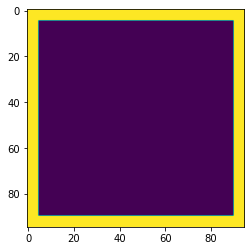

In [39]:
plt.imshow(mask)

In [12]:
import skimage

True
ux, nrmse,  0.00
uy, nrmse,  0.00
TS
ux, nrmse,  0.71
uy, nrmse,  0.77
C-W
ux, nrmse,  1.02
uy, nrmse,  0.55
C-UW
ux, nrmse,  0.08
uy, nrmse,  0.07


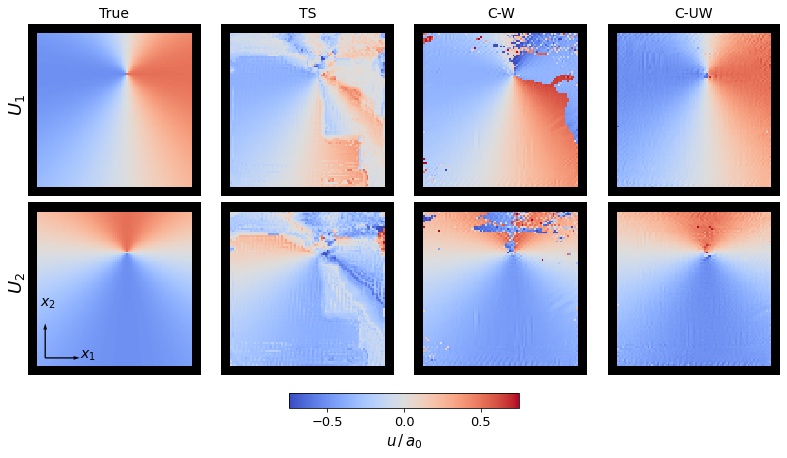

In [87]:
fig, axes = plt.subplots(2, 4, figsize=[11,6.2], constrained_layout=True)

labels1 = ['True', 'TS', 'C-W', 'C-UW']
for i, d in enumerate([true_items, recons_separate, recons_direct, recons_proj]):
    ux_diffs = d['ux'] - true_items['ux']
    ux_diffs_mean = ux_diffs[5:-5, 5:-5].mean()
    ux_this = d['ux'] - ux_diffs_mean
    print(labels1[i])
    
    nrmsex = skimage.metrics.normalized_root_mse( true_items['ux'][5:-5,5:-5], ux_this[5:-5,5:-5])
    print(f'ux, nrmse, {nrmsex: 3.2f}') 
    #print('ux, ssim', skimage.metrics.structural_similarity(true_items['ux'][5:-5,5:-5], ux_this[5:-5,5:-5]))
    ux_this[mask] = np.nan
    cp = axes[0, i].pcolormesh(ux_this, cmap=cmap, vmin=-0.75, vmax=0.75,rasterized=True)
    axes[0, i].set_axis_off()
    axes[0,i].set_aspect('equal')
    
    uy_diffs = d['uy'] - true_items['uy']
    uy_diffs_mean = uy_diffs[5:-5, 5:-5].mean()
    uy_this = d['uy'] - uy_diffs_mean
    uy_true = true_items['uy'].copy()
    
    nrmsey = skimage.metrics.normalized_root_mse( true_items['uy'][5:-5,5:-5], uy_this[5:-5,5:-5])
    print(f'uy, nrmse, {nrmsey: 3.2f}') 
    uy_this[mask] = np.nan
    cp = axes[1, i].pcolormesh(uy_this, cmap=cmap, vmin=-0.75, vmax=0.75, rasterized=True)
    axes[1, i].set_axis_off()
    axes[1, i].set_aspect('equal')

axes[0, 0].set_title('True', fontsize=14)
axes[0, 1].set_title('TS', fontsize=14)
axes[0, 2].set_title('C-W', fontsize=14)
axes[0, 3].set_title('C-UW', fontsize=14)

axes[0, 0].text(-0.12, 0.5, r'$U_1$', fontsize=18, transform=axes[0, 0].transAxes, rotation=90)
axes[1, 0].text(-0.12, 0.5, r'$U_2$', fontsize=18, transform=axes[1, 0].transAxes, rotation=90)


axes[1, 0].quiver(0.1, 0.1, 0., 1, scale=5, color='k', transform=axes[1, 0].transAxes)
axes[1, 0].quiver(0.1, 0.1, 1., 0, scale=5, color='k', transform=axes[1, 0].transAxes)
axes[1, 0].text(0.3, 0.1, r'$x_1$', color='k', fontsize=14, transform=axes[1, 0].transAxes)
axes[1, 0].text(0.07, 0.4, r'$x_2$', color='k', fontsize=14, transform=axes[1, 0].transAxes)


cb = fig.colorbar(cp, ax=axes[:3, :4], shrink=0.3, location='bottom', aspect=15)
cb.set_label(label=r'$u\,/\,a_0$', size=15, weight='bold')
cb.ax.tick_params(labelsize=13)

plt.savefig('displacements.pdf', bbox_inches='tight', dpi=600)

In [19]:
true_items['ux'].min(), true_items['ux'].max()

(-0.5120890661113978, 0.5121638924455826)

In [20]:
true_items['uy'].min(), true_items['uy'].max()

(-0.5120890661113978, 0.5120890661113978)

0.5057647557070178 0.5121638924455826


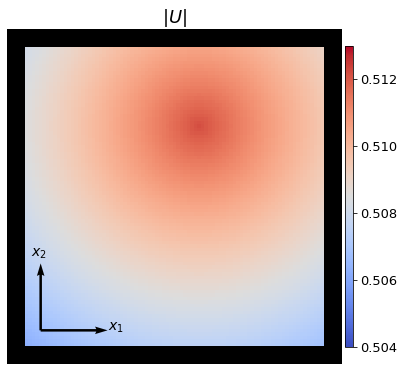

In [28]:
u_mag_true = (true_items['ux']**2 + true_items['uy']**2)**0.5
print(u_mag_true.min(), u_mag_true.max())
u_mag_true[mask] = np.nan

fig, ax = plt.subplots(1,1, figsize=[5.5, 5], constrained_layout=True)
cp = ax.pcolormesh(u_mag_true, cmap=cmap, vmin=0.504, vmax=0.513, rasterized=True)
ax.set_title(r'$|U|$', weight='bold', fontsize=18)
ax.set_axis_off()
ax.set_aspect('equal')    

#formatter = mpl.ticker.ScalarFormatter(useOffset=0.501, useMathText=False)
#formatter.set_scientific('off')
#formatter.set_powerlimits((0,1))
cb = plt.colorbar(cp, pad=0.01, aspect=40, shrink=0.9)#, format=formatter)
cb.ax.tick_params(labelsize=13, rotation=0)

ax.quiver(0.1, 0.1, 0., 1, scale=5, color='k', transform=ax.transAxes)
ax.quiver(0.1, 0.1, 1., 0, scale=5, color='k', transform=ax.transAxes)
ax.text(0.3, 0.1, r'$x_1$', color='k', fontsize=14, transform=ax.transAxes)
ax.text(0.07, 0.32, r'$x_2$', color='k', fontsize=14, transform=ax.transAxes)
#cb.set_label(label=r'$u\,/\,a_0$', size=15, weight='bold', rotation=0)
plt.savefig('displacement_mag_true.pdf', bbox_inches='tight', dpi=600)
plt.show()


In [71]:
circmean

<function scipy.stats.morestats.circmean(samples, high=6.283185307179586, low=0, axis=None, nan_policy='propagate')>

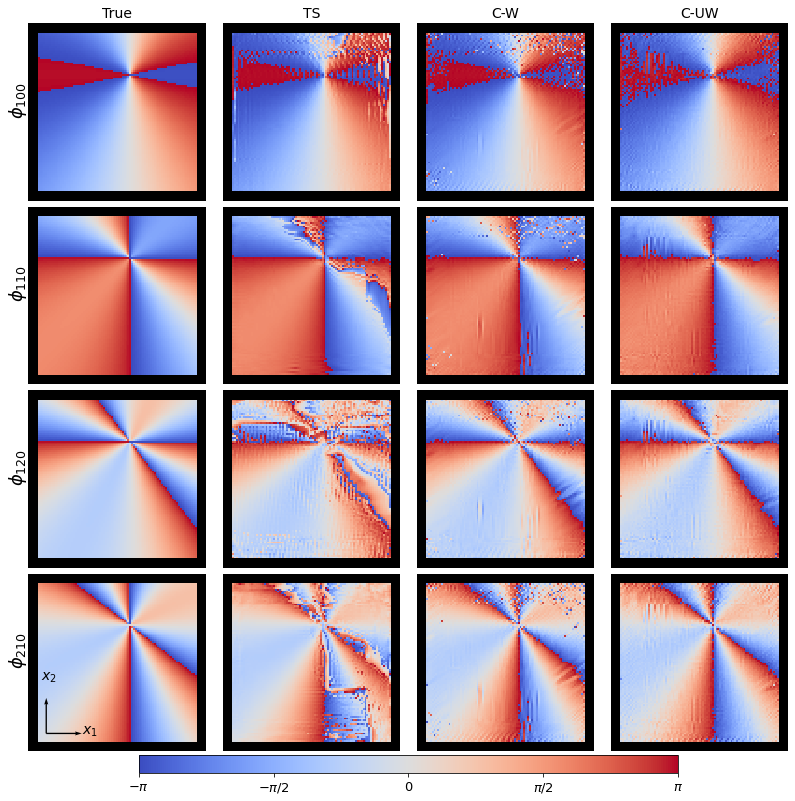

In [80]:
fig, axes = plt.subplots(4, 4, figsize=[11,11], constrained_layout=True)


for i, d in enumerate([true_items, recons_separate, recons_direct, recons_proj]):
    for j, ph in enumerate(['phi100', 'phi110', 'phi120', 'phi210']):
        if i == 0:
            rho_true = recons._rho_true[j]
            phi_this = np.angle(rho_true)
            phi_true = phi_this[:]
        else:
            rho_true = recons._rho_true[j]
            rollr, errr, phaser = phase_cross_correlation(rho_true[5:-5,5:-5], 
                                                          d['rho'][j][5:-5,5:-5], 
                                                          upsample_factor=10)

            rho_this = d['rho'][j] * np.exp(1j * phaser)
            phi_this = np.angle(rho_this)
            
            #rho_this = d['rho'][j]
            #phi_this = np.angle(rho_this)
            #print(f'{ph}, nrmse', errr)
            
        #recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        #print(f'{ph}, nrmse', skimage.metrics.normalized_root_mse(phi_true[5:-5,5:-5], phi_this[5:-5,5:-5]))
        phi_this[mask] = np.nan
        cp = axes[j, i].pcolormesh(phi_this, cmap=cmap, vmin=-np.pi, vmax=np.pi, rasterized=True)
        axes[j, i].set_axis_off()
        axes[j,i].set_aspect('equal')

axes[0, 0].set_title('True', fontsize=14)
axes[0, 1].set_title('TS', fontsize=14)
axes[0, 2].set_title('C-W', fontsize=14)
axes[0, 3].set_title('C-UW', fontsize=14)

axes[0, 0].text(-0.12, 0.5, r'$\phi_{100}$', fontsize=18, transform=axes[0, 0].transAxes, rotation=90)
axes[1, 0].text(-0.12, 0.5, r'$\phi_{110}$', fontsize=18, transform=axes[1, 0].transAxes, rotation=90)
axes[2, 0].text(-0.12, 0.5, r'$\phi_{120}$', fontsize=18, transform=axes[2, 0].transAxes, rotation=90)
axes[3, 0].text(-0.12, 0.5, r'$\phi_{210}$', fontsize=18, transform=axes[3, 0].transAxes, rotation=90)

axes[3, 0].quiver(0.1, 0.1, 0., 1, scale=5, color='k', transform=axes[3, 0].transAxes)
axes[3, 0].quiver(0.1, 0.1, 1., 0, scale=5, color='k', transform=axes[3, 0].transAxes)

axes[3, 0].text(0.3, 0.1, r'$x_1$', color='k', fontsize=14, transform=axes[3, 0].transAxes)
axes[3, 0].text(0.07, 0.4, r'$x_2$', color='k', fontsize=14, transform=axes[3, 0].transAxes)

cb = fig.colorbar(cp, ax=axes[:4, :4], ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                  shrink=0.7, location='bottom', aspect=30, pad=0.005)
cb.ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'0', r'$\pi/2$', r'$\pi$'])
cb.ax.tick_params(labelsize=13)

plt.savefig('phases.pdf', bbox_inches='tight', dpi=600)

In [14]:
vmax = 0
for i, d in enumerate([true_items, recons_separate, recons_direct, recons_proj]):
    for j in range(4):
        if i == 0:
            rho_true = recons._rho_true[j]
            mag_this = np.abs(rho_true)
        else:
            rho_true = recons._rho_true[j]
            mag_this = np.abs(d['rho'][j])
        vmax = np.maximum(vmax, mag_this.max())
print(vmax)

0.3379391133785248


TS    , 100    0.39
TS    , 110    0.40
TS    , 120    1.15
TS    , 210    0.61
CW    , 100    0.28
CW    , 110    0.28
CW    , 120    0.28
CW    , 210    0.28
C-UW    , 100    0.17
C-UW    , 110    0.17
C-UW    , 120    0.17
C-UW    , 210    0.17


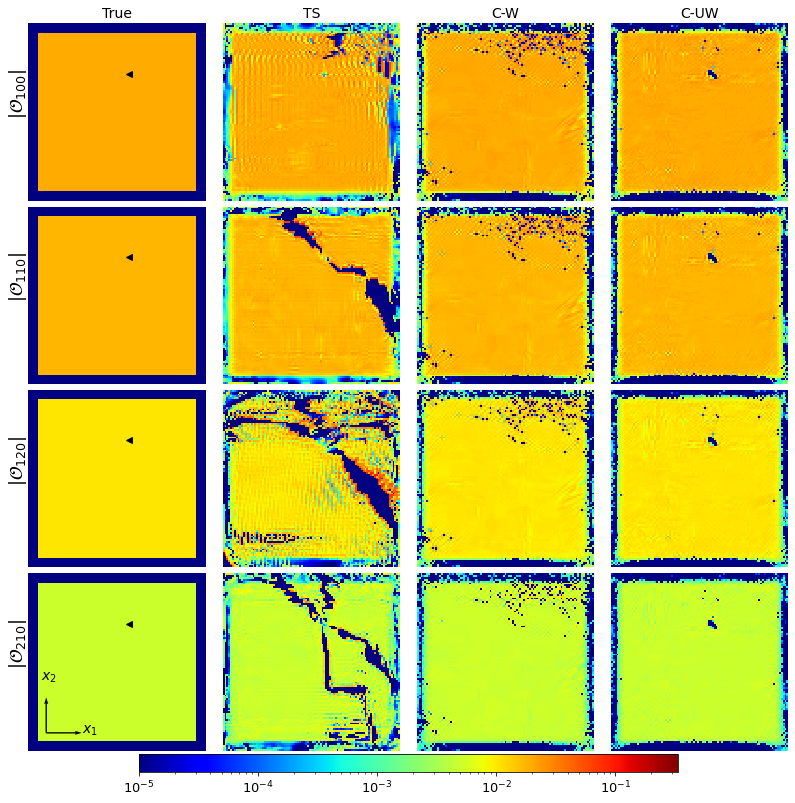

In [19]:
fig, axes = plt.subplots(4, 4, figsize=[11,11], constrained_layout=True)

labels1 = ['True', 'TS', 'CW', 'C-UW']
labels2 = ['100', '110', '120', '210']

for i, d in enumerate([true_items, recons_separate, recons_direct, recons_proj]):
    for j in range(4):
        if i == 0:
            rho_true = recons._rho_true[j]
            mag_this = np.abs(rho_true)
        else:
            rho_true = recons._rho_true[j]
            mag_this = np.abs(d['rho'][j])
            
            nrmse = skimage.metrics.normalized_root_mse(np.abs(rho_true), mag_this)
            print(f'{labels1[i]}    , {labels2[j]}    {nrmse:3.2f}')
        mag_this[mag_this < 1e-5] = 1e-5
        
        #recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        #new_cmap = truncate_colormap(plt.get_cmap('coolwarm'), minval=0.5, maxval=1.0)
        cp = axes[j, i].pcolormesh(mag_this, cmap='jet',
                            norm=LogNorm(vmin=1e-5, vmax=vmax), rasterized=True)
        #cp = axes[j, i].pcolormesh(mag_this, cmap=cmap)#, vmin=-np.pi, vmax=np.pi)
        axes[j, i].set_axis_off()
        axes[j,i].set_aspect('equal')

axes[0, 0].set_title('True', fontsize=14)
axes[0, 1].set_title('TS', fontsize=14)
axes[0, 2].set_title('C-W', fontsize=14)
axes[0, 3].set_title('C-UW', fontsize=14)

axes[0, 0].text(-0.12, 0.5, r'$|\mathcal{O}_{100}|$', fontsize=18, transform=axes[0, 0].transAxes, rotation=90)
axes[1, 0].text(-0.12, 0.5, r'$|\mathcal{O}_{110}|$', fontsize=18, transform=axes[1, 0].transAxes, rotation=90)
axes[2, 0].text(-0.12, 0.5, r'$|\mathcal{O}_{120}|$', fontsize=18, transform=axes[2, 0].transAxes, rotation=90)
axes[3, 0].text(-0.12, 0.5, r'$|\mathcal{O}_{210}|$', fontsize=18, transform=axes[3, 0].transAxes, rotation=90)

axes[3, 0].quiver(0.1, 0.1, 0., 1, scale=5, color='k', transform=axes[3, 0].transAxes)
axes[3, 0].quiver(0.1, 0.1, 1., 0, scale=5, color='k', transform=axes[3, 0].transAxes)

axes[3, 0].text(0.3, 0.1, r'$x_1$', color='k', fontsize=14, transform=axes[3, 0].transAxes)
axes[3, 0].text(0.07, 0.4, r'$x_2$', color='k', fontsize=14, transform=axes[3, 0].transAxes)

axes[0,0].plot(54, 68, "<k")
#axes[0,1].plot(54, 68, "<w", alpha=0.3)
#axes[0,2].plot(54, 68, "<w", alpha=0.3)
#axes[0,3].plot(54, 68, "<w", alpha=0.3)

axes[1,0].plot(54, 68, "<k")
#axes[1,1].plot(54, 68, "<w", alpha=0.3)
#axes[1,2].plot(54, 68, "<w", alpha=0.3)
#axes[1,3].plot(54, 68, "<w", alpha=0.3)

axes[2,0].plot(54, 68, "<k")
#axes[2,1].plot(54, 68, "<w", alpha=0.3)
#axes[2,2].plot(54, 68, "<w", alpha=0.3)
#axes[2,3].plot(54, 68, "<w", alpha=0.3)

axes[3,0].plot(54, 68, "<k")
#axes[3,1].plot(54, 68, "<w", alpha=0.3)
#axes[3,2].plot(54, 68, "<w", alpha=0.3)
#axes[3,3].plot(54, 68, "<w", alpha=0.3)

cb = fig.colorbar(cp, ax=axes[:4, :4], 
                  shrink=0.7, location='bottom', aspect=30, pad=0.005)
#cb.ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'0', r'$\pi/2$', r'$\pi$'])
cb.ax.tick_params(labelsize=13)

plt.savefig('magnitudes.pdf', bbox_inches='tight', dpi=600)

In [36]:
sm.sample.params.sample_pix_size

0.005844363636363636

In [37]:
for s in sm.simulations_per_peak:
    print(s.diffraction_patterns.mean())

125.76588093278464
77.66949684499315
31.797204938271605
7.1580438957476


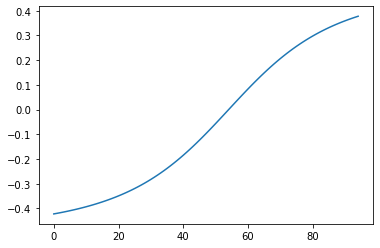

In [92]:
plt.plot(ux_true[31])

In [93]:
sm.sample.strain_params

PointInclusionStrainParams(n_inclusion=1, inclusion_radius=3.0, alpha=0.025, mag=0.0002, name='strain3', coords_inclusion=array([[0.11688727, 0.04091055]]))

In [95]:
0.11688727 / 0.005844363636363636

19.999999533349925

In [98]:
0.04091 / 0.005844363636363636

6.999906669985068

In [94]:
sm.sample.params

SampleParams(sample_pix_size=0.005844363636363636, wavelength=0.00013776, npix_xy=200, npix_depth=100, grain_width=0.5, grain_height=0.5, film_thickness=0.1, npix_delta_x=5, npix_delta_y=5, lattice=array([0.0003905, 0.0003905, 0.0003905]), strain_type='point_inclusion', random_scaled_magnitudes=True, magnitudes_max=1.0, grain_width_delta=0.5584436363636364, grain_height_delta=0.5584436363636364, npix_grain_width_only=86, npix_grain_height_only=86)

In [96]:
86 // 2

43

In [99]:
43 + 5 + 7

55

In [100]:
43 + 5 + 20

68